In [1]:
import sys
sys.path.append('../../')
from localconfig import BASE_PATH,EXPS

import pathlib
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate
np.set_printoptions(threshold=1050)
from pprint import pprint

import maxone_code.data
import maxone_code.fig
from maxone_code.data import Experiment
from maxone_code.artifact.remover import ArtifactAssay

In [2]:
EXP,FILE=(EXPS[1],'searching-9295-9515.raw.h5')
path=pathlib.Path(BASE_PATH).joinpath('data',EXP,'raw',FILE)

In [3]:
from maxone_code.spikedetect import BandPassFilter,HighPassFilter

bpfs = {
    'BPF1000': BandPassFilter(lowcut=250, highcut=1000, order=4),
    'BPF2000': BandPassFilter(lowcut=250, highcut=2000, order=4),
    'BPF3000': BandPassFilter(lowcut=250, highcut=3000, order=4),
    'BPF4000': BandPassFilter(lowcut=250, highcut=4000, order=4),
    'BPF5000': BandPassFilter(lowcut=250, highcut=5000, order=4),
    'BPF7500': BandPassFilter(lowcut=250, highcut=7500, order=4),
    'HPF': HighPassFilter(lowcut=250,order=4),
    }

In [4]:
assay_list={}
for name,bpf in bpfs.items():
    assay=ArtifactAssay(path,lookforframe=100)
    assay.bpf=bpf
    assay.loaddata()
    assay_list[name]=assay

In [5]:
assay=assay_list['HPF']

### フィルターが違うとアーチファクトの形状も異なる

In [6]:
assay.data_filtered_m_for_spline.shape

(5, 712, 760)

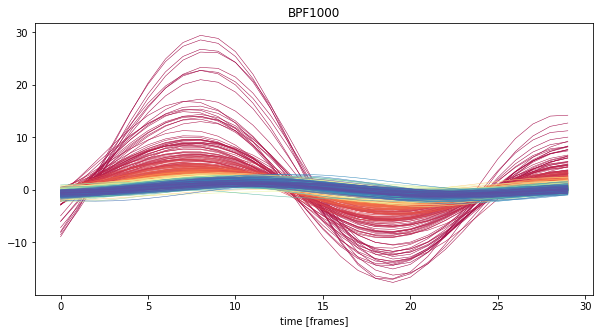

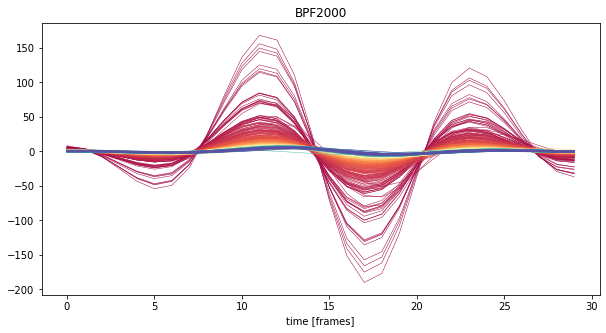

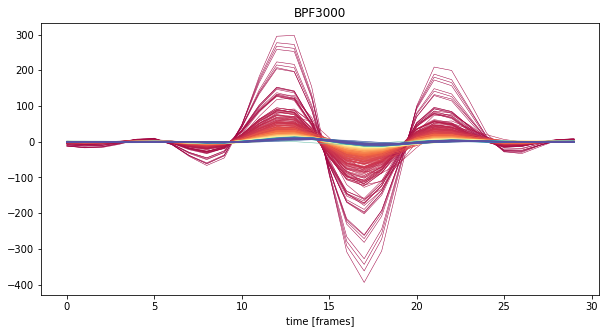

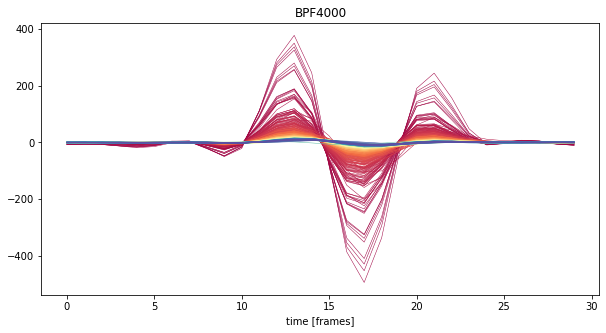

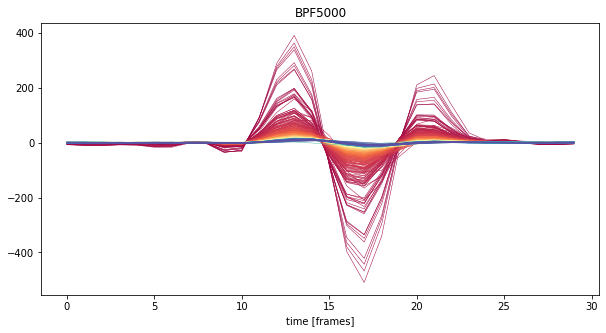

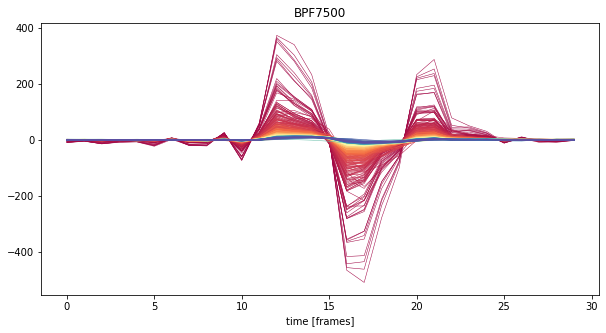

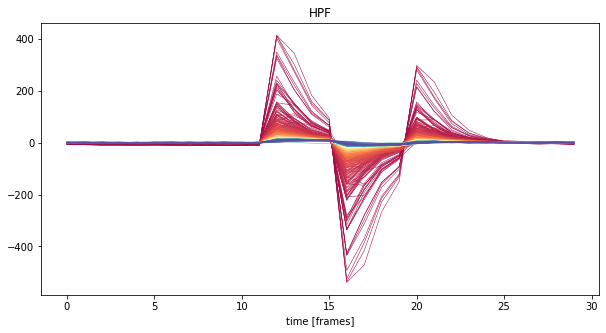

In [7]:
for name,assay in assay_list.items():
#     assay.disp_filtered(trange=1, frange=np.s_[:20], title=name)
    assay.disp_data(assay.data_filtered_m,trange=1, frange=np.s_[290:320], title=name)

### スプライン補間の次数の違い
- 次数が大きいほど、微分値が連続的になる
- 3次で十分

In [8]:
from scipy import interpolate


Ks = [1,2,3,4,5]

def makeSplineData(assay):
    shape = assay.data_filtered_m.shape
    shape_ = (len(Ks),) + shape[:2] + (shape[2]*10,)
    splined_data = np.zeros(shape_)

    for i,trial in enumerate(assay.data_filtered_m):
        for j,chan in enumerate(trial):
            for k in Ks:
                x = np.arange(0, shape[2], 1)
                s = interpolate.InterpolatedUnivariateSpline(x, chan, k=k)
                xnew = np.arange(0, shape[2], 1/10)
                splined_data[k-1,i,j] = s(xnew)
    
    assay.splined_data=splined_data

In [9]:
for assay in assay_list.values():
    makeSplineData(assay)

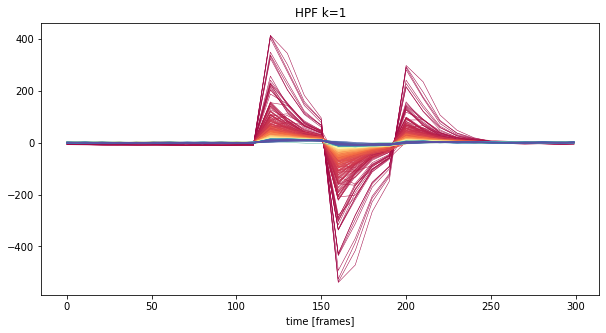

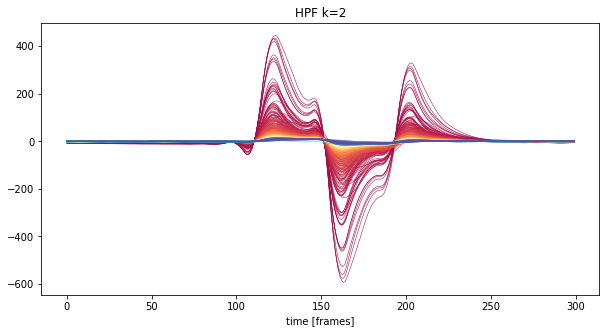

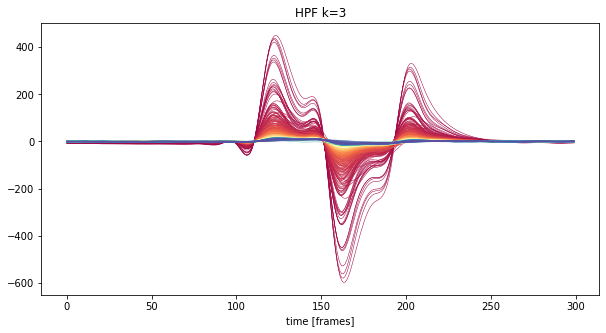

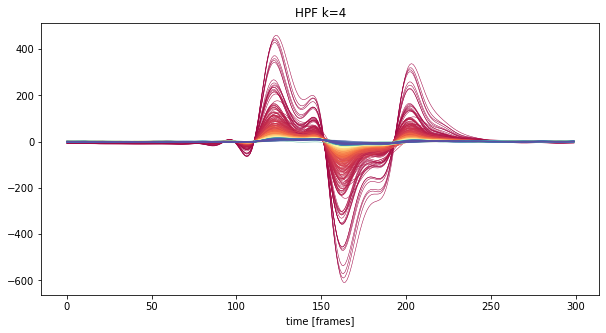

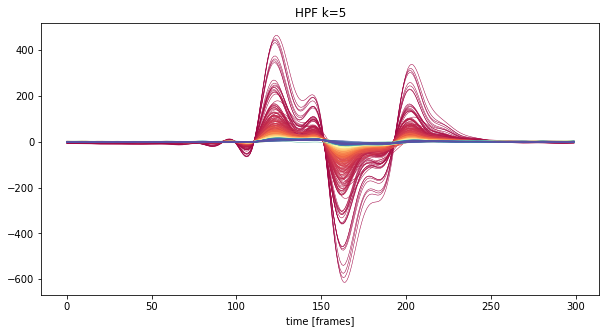

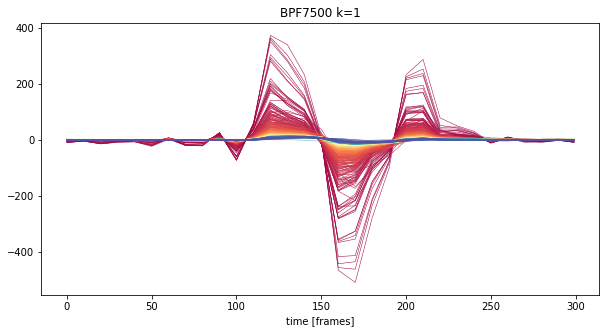

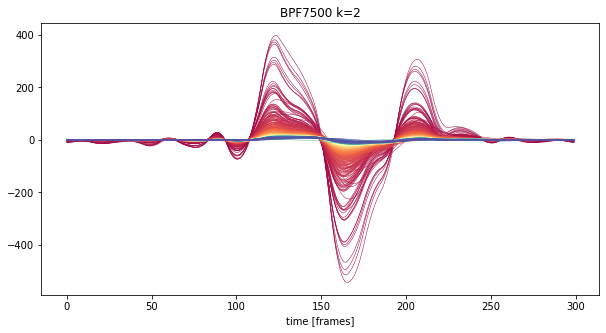

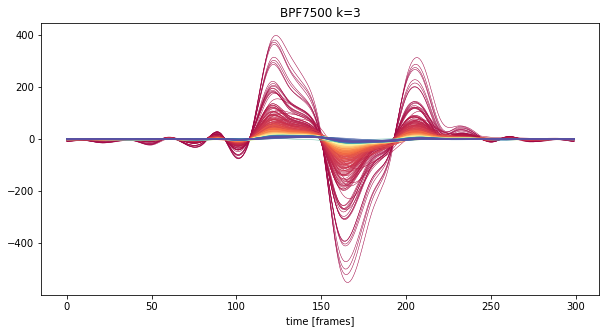

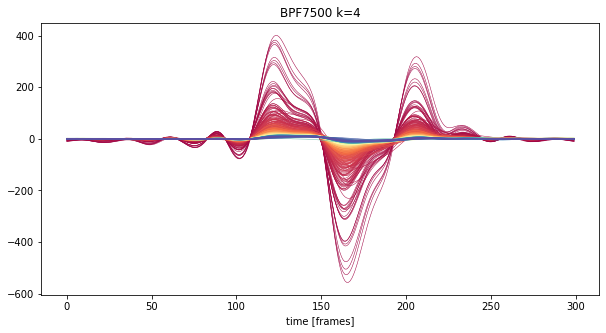

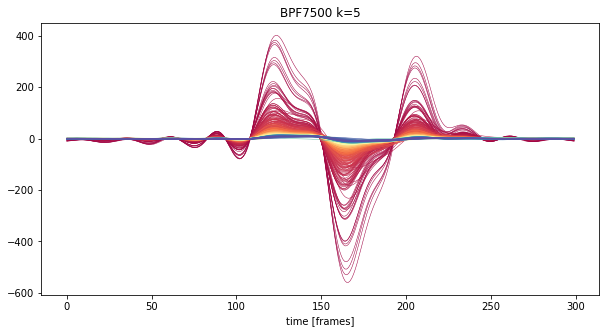

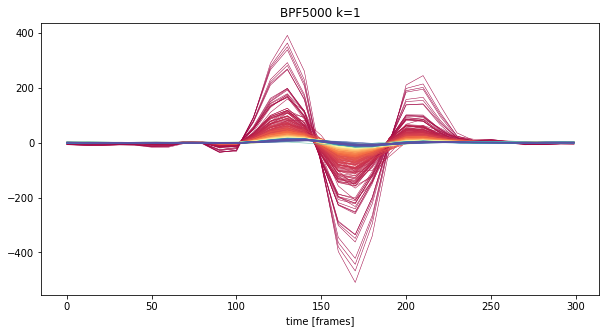

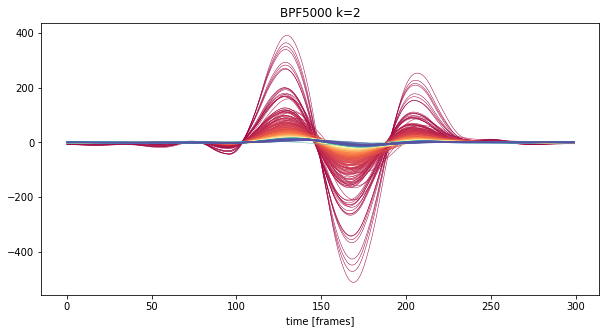

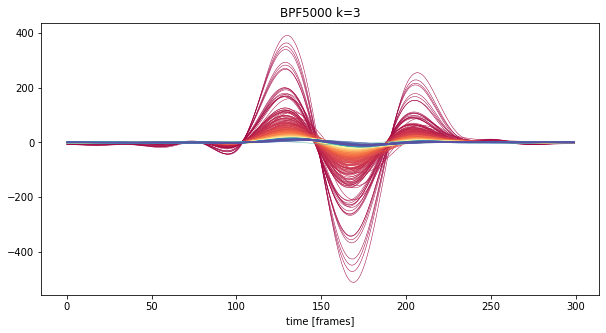

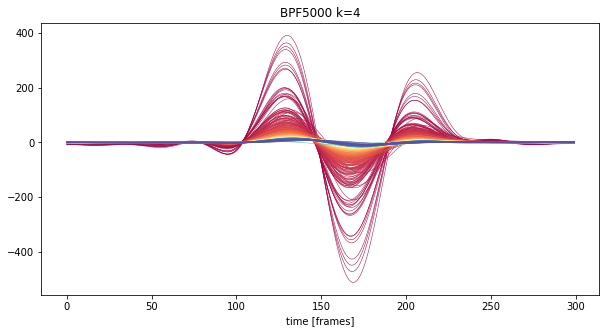

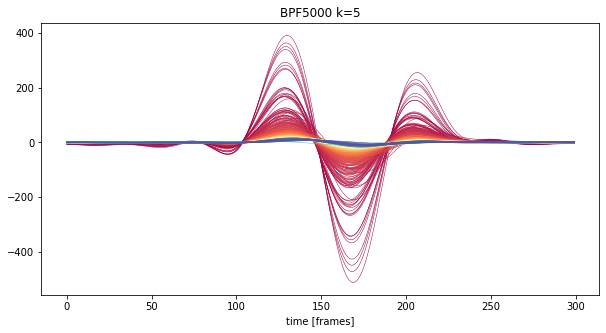

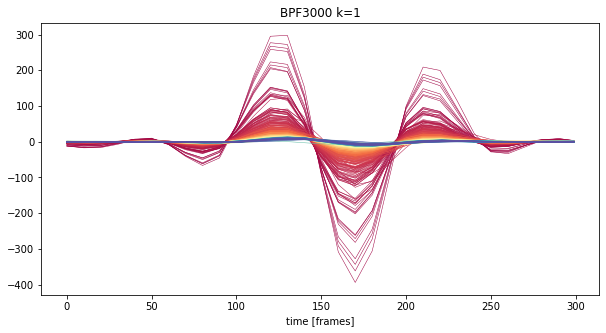

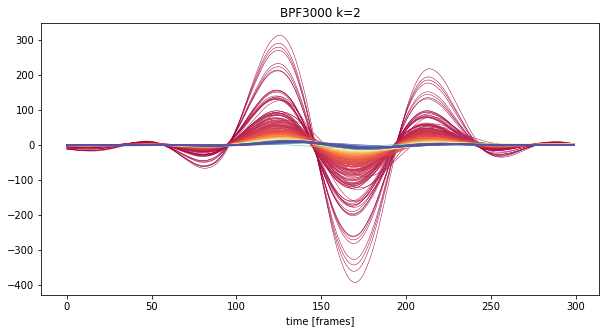

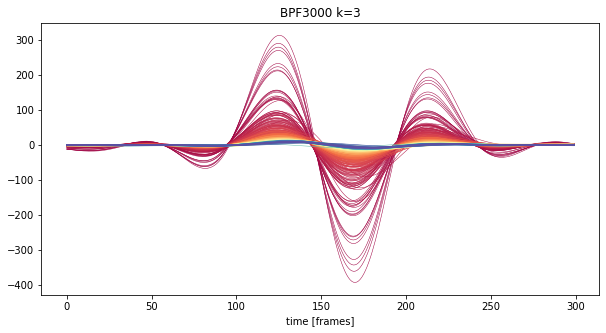

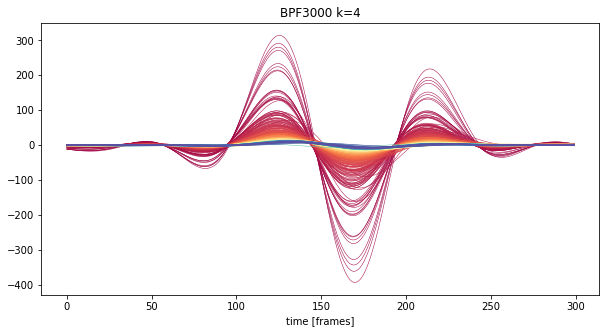

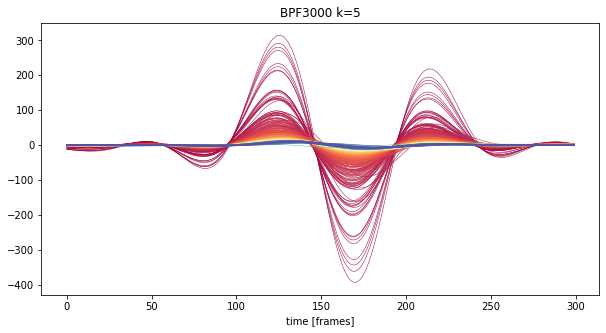

In [41]:
for key in ['HPF','BPF7500','BPF5000','BPF3000','BPF2000']:
    assay = assay_list[key]
    for i,k in enumerate(Ks):
        title= key + ' k=' + str(k)
        assay.disp_data(assay.splined_data[i], trange=[1],frange=np.s_[2900:3200], title=title)

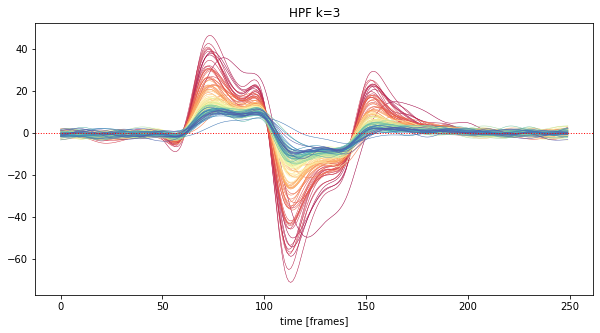

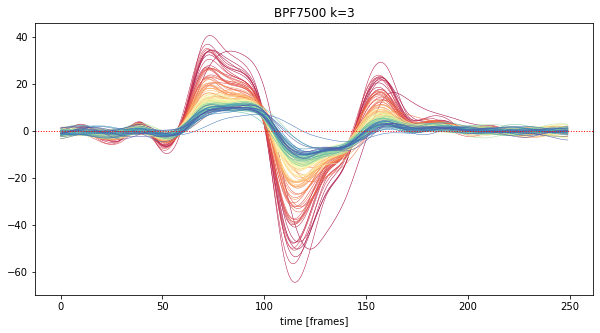

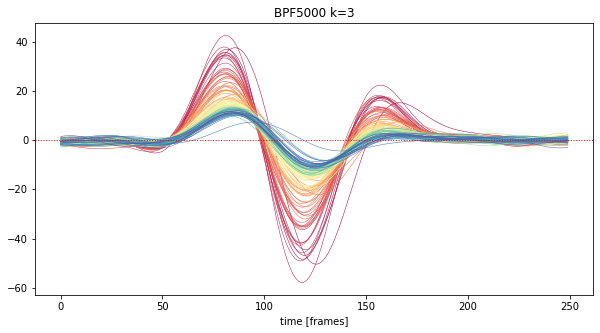

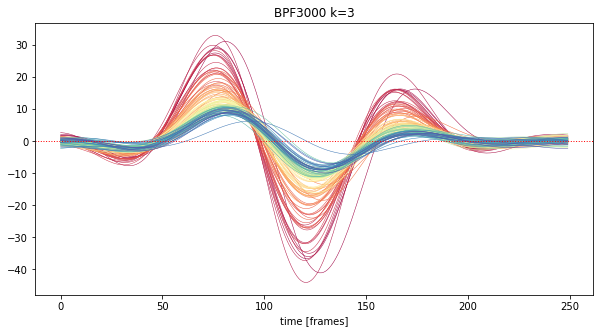

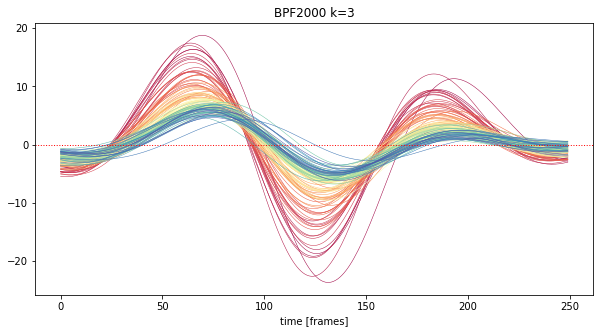

In [42]:
for key in ['HPF','BPF7500','BPF5000','BPF3000','BPF2000']:
    assay = assay_list[key]
    k=3
    title= key + ' k=' + str(k)
    assay.disp_data(assay.splined_data[k-1], trange=[1],frange=np.s_[2950:3200], xids=np.s_[100::5], title=title, draw_xaxis=True)

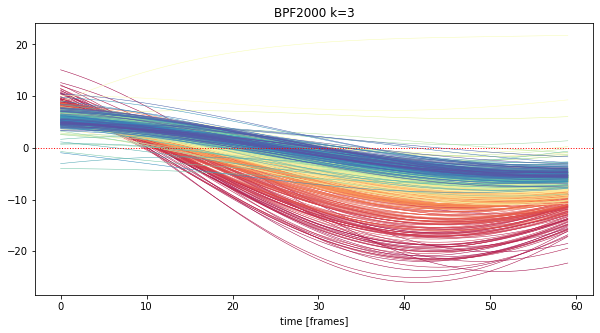

In [12]:
assay = assay_list['BPF2000']
k=3
assay.disp_data(assay.splined_data[k-1], trange=[2],frange=np.s_[3030:3090], xids=np.s_[100::], title=title, draw_xaxis=True)

### 波形の位相を揃える

In [47]:
k=3

def trigeredData(assay):
    ki=k-1
    window=300
    shape=assay.splined_data.shape[1:-1] + (window,) # (trial, chan, window)
    triggered_data = np.zeros(shape)
    resampled_data=np.zeros(assay.splined_data.shape[1:]) # (trial, chan, window)
    look_for_frame=np.s_[3030:3090]
    start=look_for_frame.start
    stop=look_for_frame.stop
    
    offset=-1
    no_triggered_chan=set()  #  あるtrialでx軸との交差点が見つからなかった電極
    for i,trial in enumerate(assay.data_filtered_m):
        for j,chan in enumerate(trial):
            a=assay.splined_data[ki,i,j,start:stop-1]
            b=assay.splined_data[ki,i,j,start+1:stop]
            c=b*a
            indices=np.array(np.where(c < 0)).T
            if len(indices)==0:
                # triggered_data[i,j,:]=0 
                no_triggered_chan.add(j)
            else:
                center=indices[0,0]+look_for_frame.start
                window_frame=np.s_[center-window//2:center+window//2]
                triggered_data[i,j,:]=assay.splined_data[ki,i,j,window_frame]
                
    assay.triggered_data=triggered_data
    assay.no_triggered_chan=no_triggered_chan

In [48]:
for key in ['HPF','BPF7500','BPF5000','BPF3000','BPF2000']:
    print(key)
    assay = assay_list[key]
    trigeredData(assay)
    print(assay.no_triggered_chan)

HPF
{689, 466, 427, 574}
BPF7500
{689, 466, 427, 574}
BPF5000
{689, 466, 427}
BPF3000
{689, 466, 427, 414}
BPF2000
{541, 646, 574, 584, 427, 621, 689, 466, 701, 414}


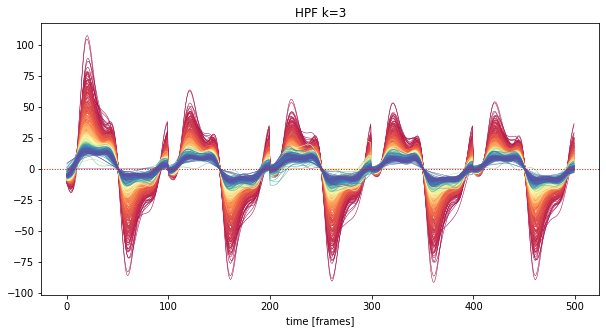

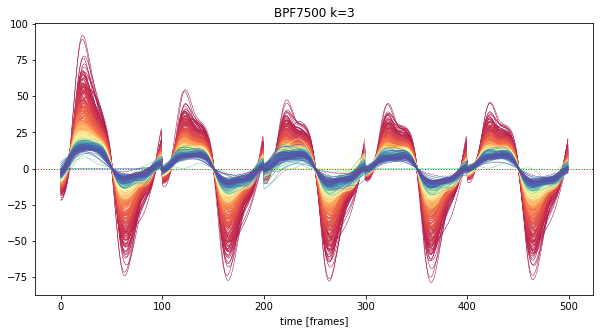

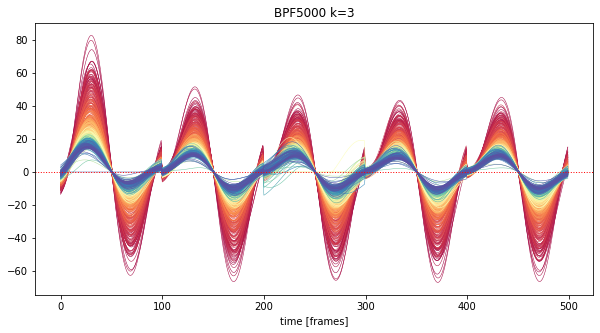

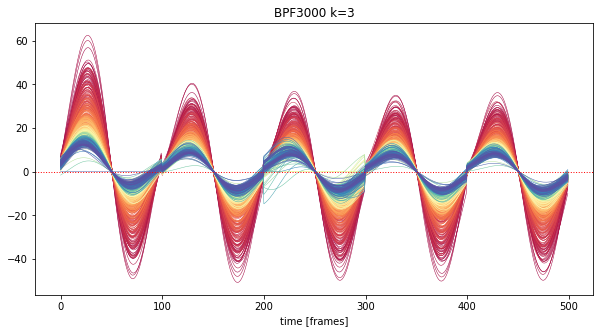

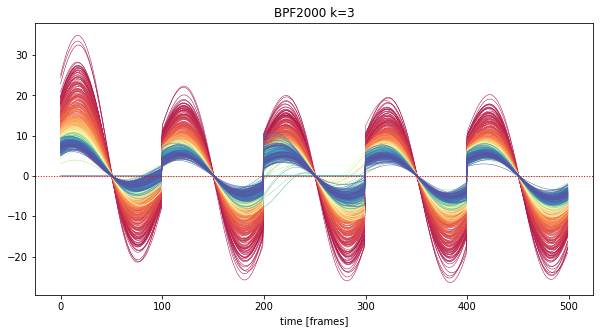

In [50]:
for key in ['HPF','BPF7500','BPF5000','BPF3000','BPF2000']:
    assay = assay_list[key]
    title= key + ' k=' + str(k)
    # assay.disp_data(assay.triggered_data, trange=[1],frange=np.s_[:], xids=np.s_[100::], title=title, draw_xaxis=True)
    assay.disp_data(assay.triggered_data, trange=None,frange=np.s_[100:200], xids=np.s_[100::], title=title, draw_xaxis=True)

### リサンプル


In [38]:
k=3
ki=k-1
RESAMPLE_RATE=10

def resampleData(assay):
    
    shape = assay.data_filtered_m_for_spline.shape
    shape_ = (shape[2]*RESAMPLE_RATE,)
    splined_data = np.zeros(shape_) # (frame_m_for_spline)
    resampled_data_m=np.zeros(assay.data_filtered_m.shape) # (trial, chan, frame_m)

    
    no_triggered_chan=set()  #  あるtrialでx軸との交差点が見つからなかった電極
    
    for i,trial in enumerate(assay.data_filtered_m_for_spline):
        for j,chan in enumerate(trial):
            x = np.arange(0, shape[2], 1)
            s = interpolate.InterpolatedUnivariateSpline(x, chan, k=k)
            xnew = np.arange(0, shape[2], 1/RESAMPLE_RATE)
            
            splined_data = s(xnew)

            look_for_frame=np.s_[3330:3390]
            start=look_for_frame.start
            stop=look_for_frame.stop
    
            a=splined_data[start:stop-1]
            b=splined_data[start+1:stop]
            c=b*a
            indices=np.array(np.where(c < 0)).T
            if len(indices)==0:
                resampled_data_m[i,j,:]=0 
                no_triggered_chan.add(j)
            else:
                center=indices[0,0]+look_for_frame.start  # center:  3354 -> 305
                start=center - (assay.BPF_MARGIN_FRAME + 6) * RESAMPLE_RATE
                stop=start + assay.data_filtered_m.shape[2] * RESAMPLE_RATE
                resampled_data_m[i,j,:]=splined_data[start:stop:RESAMPLE_RATE]
                
    assay.resampled_data_m=resampled_data_m
    assay.resampled_data=resampled_data_m[:,:,assay.BPF_MARGIN_FRAME:-assay.BPF_MARGIN_FRAME]
    assay.no_triggered_chan=no_triggered_chan

In [45]:
for key in ['HPF','BPF7500','BPF5000','BPF3000','BPF2000']:
    print(key)
    assay = assay_list[key]
    resampleData(assay)
    print(assay.no_triggered_chan)

HPF
{689, 466, 427, 574}
BPF7500
{689, 466, 427, 574}
BPF5000
{689, 466, 427}
BPF3000
{689, 466, 427, 414}
BPF2000
{541, 646, 574, 584, 427, 621, 689, 466, 701, 414}


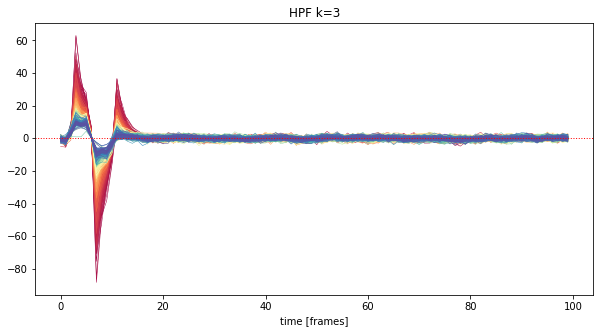

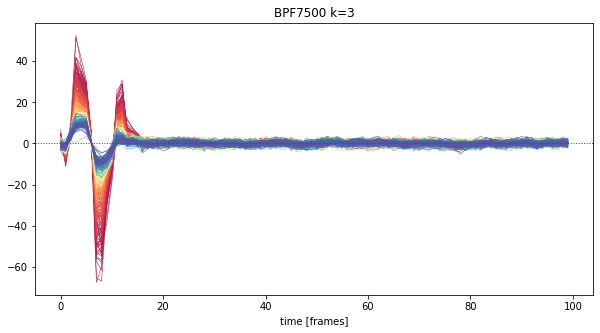

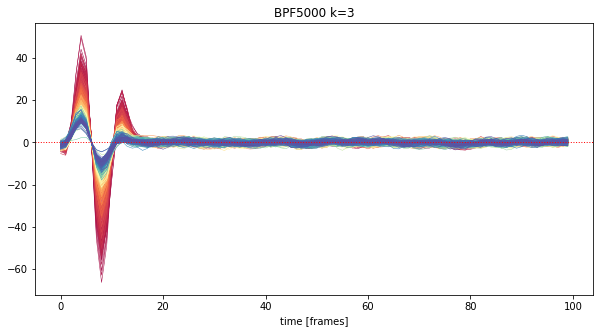

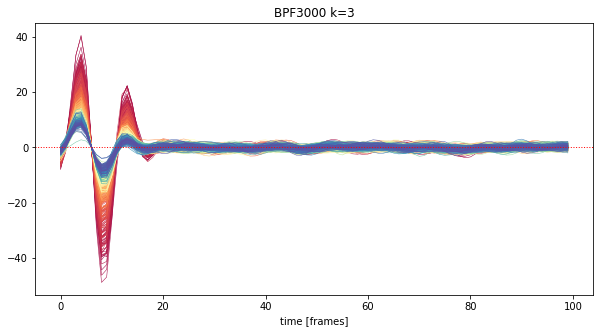

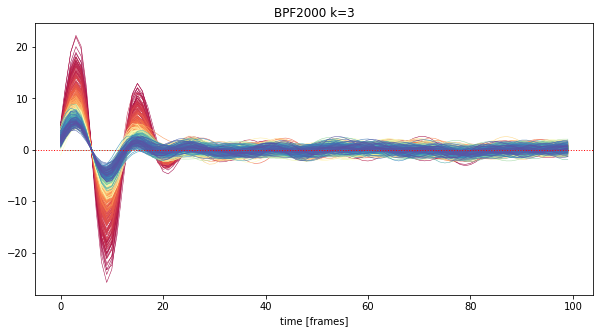

In [46]:
for key in ['HPF','BPF7500','BPF5000','BPF3000','BPF2000']:
    assay = assay_list[key]
    title= key + ' k=' + str(k)
    assay.disp_data(assay.resampled_data, trange=[1],frange=np.s_[:], xids=np.s_[100::], title=title, draw_xaxis=True)